In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
from utility import *
from torchdiffeq  import odeint

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def trace_df_dz(f, z):
    """Utility function that calculates the trace of the Jacobian df/dz.
    Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13, and in turn stolen from Cagatay Yildiz.
    Grad requires us to compute gradients with respect to one scalar which is why we loop over the 
    dimensions in z, and perform a sum across the batch. 
    Input:
        f - function output [N,d]
        z - current state [N,d]
    Returns:
        tr(df/dz) - [N]
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()
    return sum_diag.contiguous()

class CNF(nn.Module):
    """
    CNF consists of:
    1. A change in z(t) formula i.e. dz(t)/dt which we use a HyperNet to parametrize.
    HyperNet is a type of network which generates the weights for another network: https://arxiv.org/pdf/1609.09106.pdf.
    We use the HyperNet to parametrize the weights in the one layer network specified by u*h(w*z+b).
    2. A change in the log density i.e. dlog(p(z(t)))/dt formula which is the sum of the trace of df_n/dz for all hidden units.
    
    By using a continous flow, we do not have directly implement an inverse function. Rather, we just move
    the timesteps in the opposite direction, and then HyperNet will take care of inverse dynamics.
    """
    def __init__(self, dim, hidden_dim, width):
        super().__init__()
        

        self.hidden_dim = hidden_dim
        self.dim = dim
        self.base_distr = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
        self.f = HyperNet(dim, hidden_dim, width)
        
        
    def ode_rhs(self, t, states):
        """
        Inspired by Cagatay Yildiz's notebook.
        In order to solve the differential equation parametrized by the network, we must use an ode solver.
        The solver takes an ode_rhs function which takes the current states (x1 (ODE states),  dlog(p(z(t)))/dt))
        and t as inputs and outputs dynamics for these states, in our case: dz(t)/dt and dlog(p(z(t)))/dt.
        """
        z, logp_z = states
        batch_size = z.shape[0]
        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            dz_dt = self.f(t, z)
            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batch_size, 1)
            
        return (dz_dt, dlogp_z_dt)
    
    def forward(self, ts, z0, logp_diff_t0):
        """
        In the forward we simply forward or backward integrate the ODE using the ode solver.
        We must pass the timestamps ts and the initial states (guesses) z0, logp_diff_t0
        """
        zt, logp_t = odeint(self.ode_rhs, (z0, logp_diff_t0), ts, method="dopri5")
        return zt, logp_t
    
class HyperNet(nn.Module):
    """
    Width is the hyperparameter M described in NODE.
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        
        self.width = width
        self.hidden_dim = hidden_dim
        self.in_out_dim = in_out_dim
        
        #Output of network are parameters (size of b, u, w). We have $width$ different functions.
        # f(x) = u*h(w^T*x+b)
        # U has width*dim size.
        # W has width*dim size.
        # B has dim size.
        # That gives us 2*param_size + width params in total.
        
        self.param_size = width*in_out_dim
        
        self.l1 = nn.Linear(1, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, 2*self.param_size+width)
    
    def get_weights(self, t):
        params = t.reshape(1, 1)
        params = torch.tanh(self.l1(params))
        params = torch.tanh(self.l2(params))
        params = self.l3(params)
        params = params.reshape(-1)
        
        w = params[:self.param_size].reshape(self.width, self.in_out_dim, 1)
        u = params[self.param_size:2*self.param_size].reshape(self.width, 1, self.in_out_dim)
        b = params[2*self.param_size:].reshape(self.width, 1, 1)
        return w, u, b
    
    def forward(self, t, z):
        w, u, b = self.get_weights(t) # Shapes are [width, dim, 1], [width, 1, dim], [width, 1, 1]
        z = z.unsqueeze(0)
        z = z.repeat(self.width, 1, 1) #Must get z into shape [width, batch_size, dim]
        nonlinearity = torch.tanh(z@w+b)
        return (nonlinearity@u).mean(0) #Here we mean all the fs as described in NODE.
        

In [17]:
dim = 2
M = 50
batch_size= 64
epochs= 500
lr = 0.001

CNF_model = CNF(dim=dim, hidden_dim=100, width=M)
dataset = Datasets("moons")
train_loader = DataLoader(dataset, batch_size=batch_size,shuffle=False)
loss_func = TrainingLoss(dim=dim)
optimiser = torch.optim.Adam(CNF_model.parameters(), lr=lr)

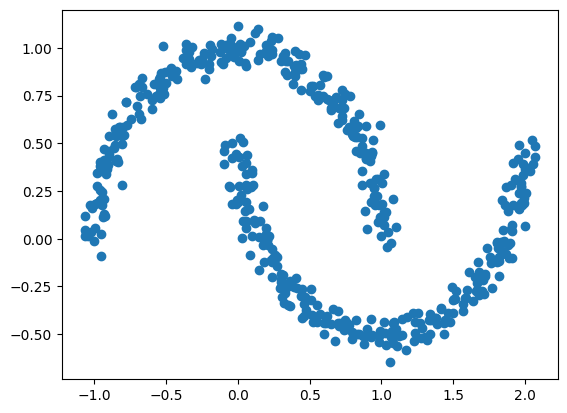

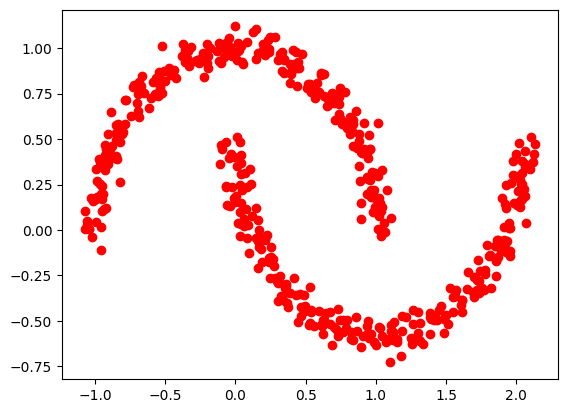

0
50
100
150
200
250
300
350
400
450


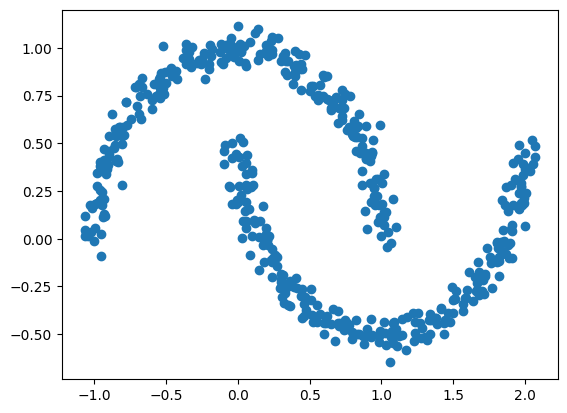

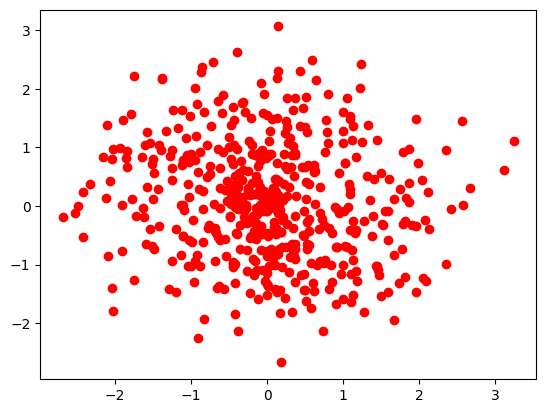

In [18]:
t1 = 1.
t0 = 0.
timeflow = torch.tensor([t1, t0]) #We flow backwards in time i.e. perform z = f^-1(x) or inverse transformation going from
#data space to prior space.
for i in range(epochs):

    z_list = []
    x_list = []
    for step, data in enumerate(train_loader):
        #Pass batch through flow.
        optimiser.zero_grad()
        init_logp_diff_t0 = torch.zeros(data.shape[0], 1).float()
        z, loss = CNF_model(timeflow, data, init_logp_diff_t0)
        z_list.append(z[-1]) #Output from CNF is the data at flow point t1 and t0. Index at -1 to get last timestep (prior).
        x_list.append(data)
        loss = -(CNF_model.base_distr.log_prob(z[-1]) - loss[-1]).mean()
        # Training step. 
        loss.backward() #Output from CNF is the loss at flow point t1 and t0. Index at -1 to get last timestep.
        optimiser.step()
    if i == 0:
        x_list = torch.cat(x_list, 0)
        z_list = torch.cat(z_list, 0)
        plt.scatter(x_list[:,0].detach().numpy(), x_list[:,1].detach().numpy())
        plt.show()
        plt.scatter(z_list[:,0].detach().numpy(), z_list[:,1].detach().numpy(), color="r")
        plt.show()
    if i%50 == 0:
        print(str(i))
x_list = torch.cat(x_list, 0)
z_list = torch.cat(z_list, 0)
plt.scatter(x_list[:,0].detach().numpy(), x_list[:,1].detach().numpy())
plt.show()
plt.scatter(z_list[:,0].detach().numpy(), z_list[:,1].detach().numpy(), color="r")
plt.show()

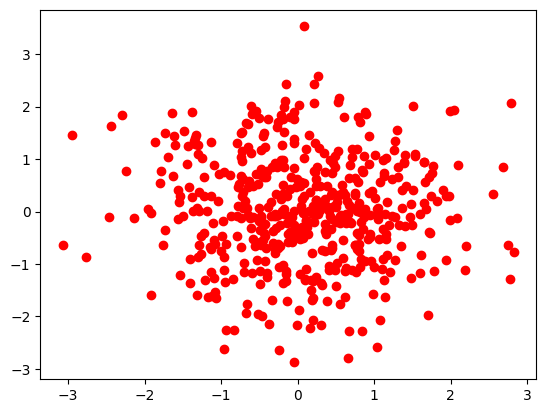

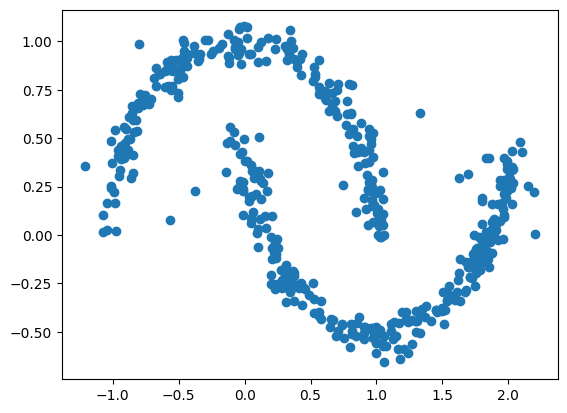

In [30]:
x_list = []
z_list = []
timeflow = torch.tensor([t0, t1]) #To sample, flow forwards in time, from t0 to t1
for i in range(500):
    with torch.no_grad():
        z = CNF_model.base_distr.rsample()
        init_logp_diff_t0 = torch.zeros(1, 1).float()
        x, loss = CNF_model(timeflow, z.unsqueeze(0), init_logp_diff_t0)
    z_list.append(z.detach().numpy())
    x_list.append(x[-1].squeeze().detach().numpy())
plt.scatter(torch.Tensor(z_list)[:,0], torch.Tensor(z_list)[:,1], color="r")
plt.show()
plt.scatter(torch.Tensor(x_list)[:,0], torch.Tensor(x_list)[:,1])
plt.show()

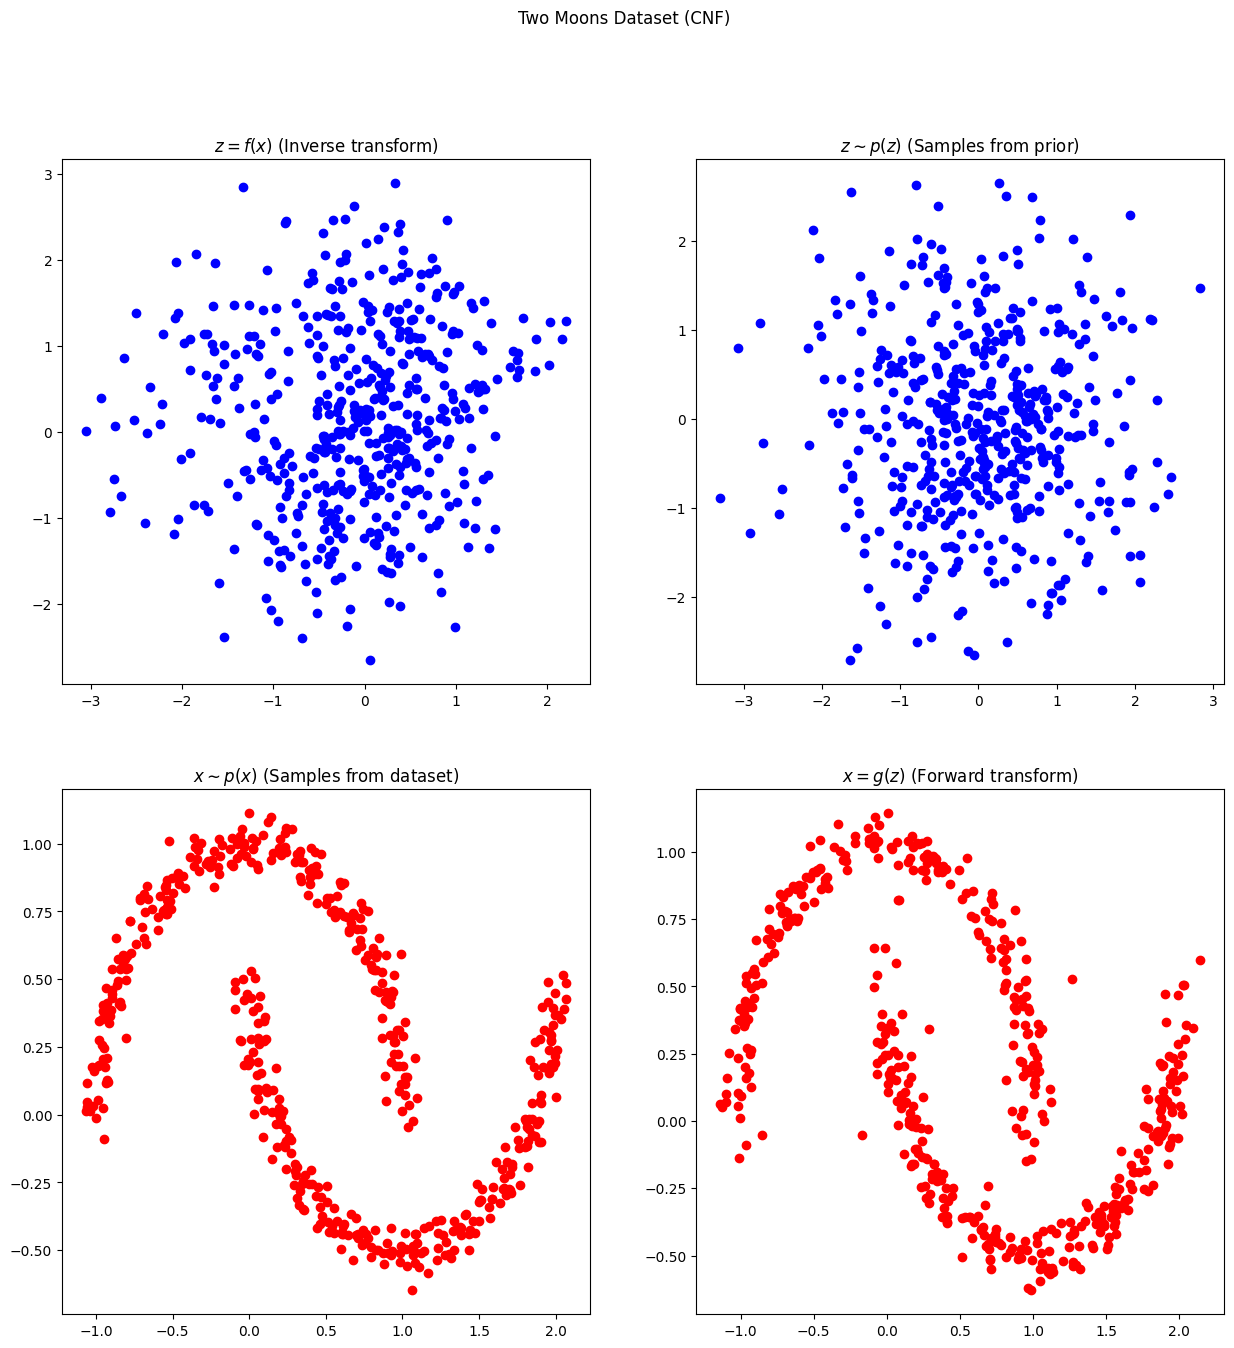

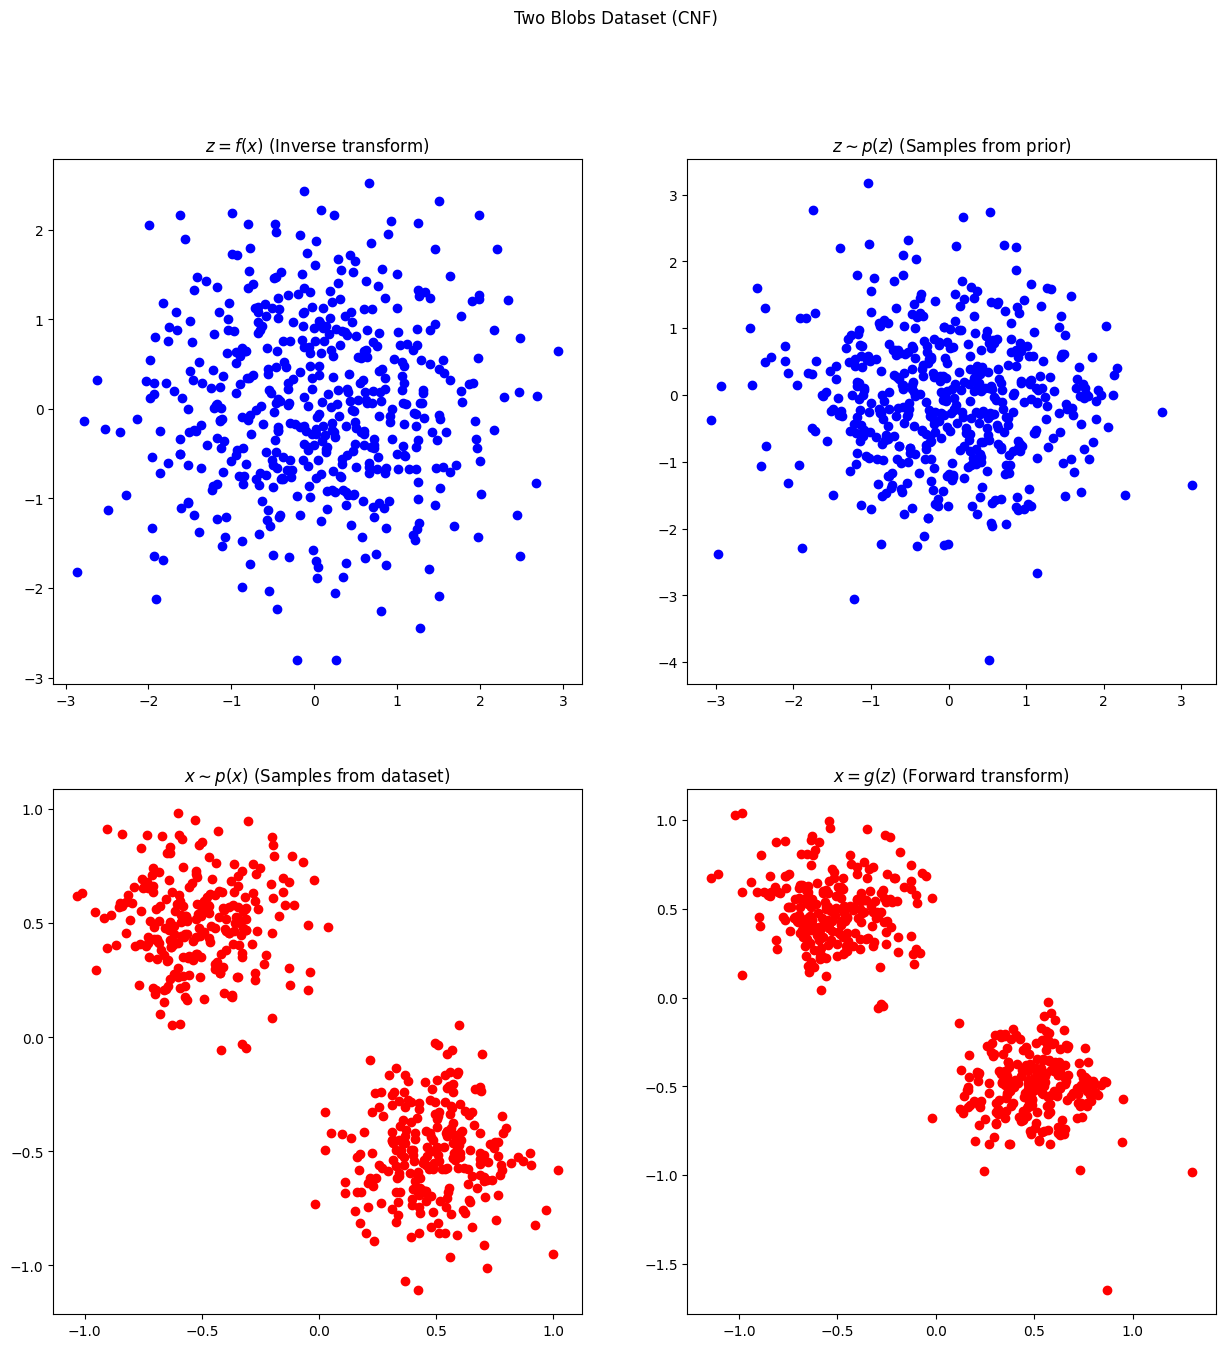

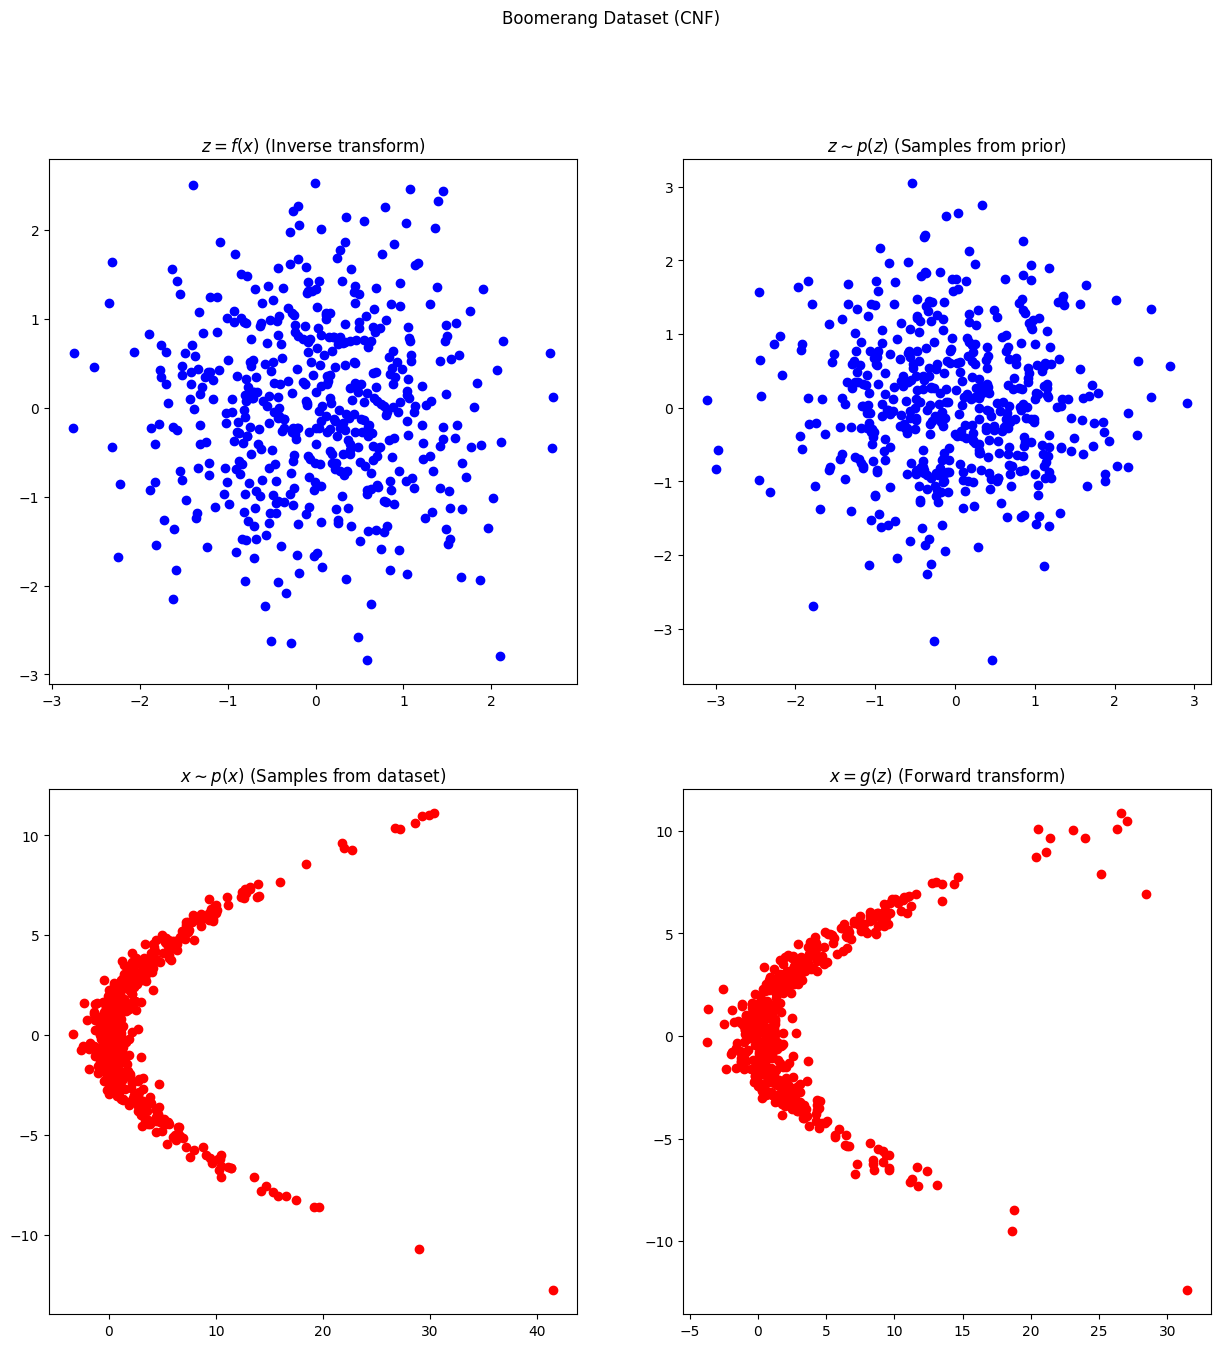

In [9]:
dim = 2
batch_size= 64
epochs= 1000
lr = 0.001
datasets = ['moons', "blobs", "boom"]
t1 = 1.
t0 = 0.
M = 32
timeflow_inverse = torch.tensor([t1, t0])
timeflow_forward = torch.tensor([t0, t1])

for dataset_name in datasets:
    CNF_model = CNF(dim=dim, hidden_dim=100, width=M)
    dataset = Datasets(dataset_name)
    train_loader = DataLoader(dataset, batch_size=batch_size,shuffle=False)
    loss_func = TrainingLoss(dim=dim)
    optimiser = torch.optim.Adam(CNF_model.parameters(), lr=lr)
    for i in range(epochs):
        z_list = []
        x_list = []
        for step, data in enumerate(train_loader):
            optimiser.zero_grad()
            init_logp_diff_t0 = torch.zeros(data.shape[0], 1).float()
            z, loss = CNF_model(timeflow_inverse, data, init_logp_diff_t0)
            z_list.append(z[-1]) #Output from CNF is the data at flow point t1 and t0. Index at -1 to get last timestep (prior).
            x_list.append(data)
            loss = -(CNF_model.base_distr.log_prob(z[-1]) - loss[-1]).mean()
            # Training step. 
            loss.backward() #Output from CNF is the loss at flow point t1 and t0. Index at -1 to get last timestep.
            optimiser.step()
    x_list_data = torch.cat(x_list, 0)
    z_list_inverse = torch.cat(z_list, 0)
    x_list_gen = []
    z_list_prior = []
    prior = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
    for i in range(500):
        with torch.no_grad():
            z = CNF_model.base_distr.rsample()
            init_logp_diff_t0 = torch.zeros(1, 1).float()
            x, loss = CNF_model(timeflow_forward, z.unsqueeze(0), init_logp_diff_t0)
        z_list_prior.append(z.detach().numpy())
        x_list_gen.append(x[-1].squeeze().detach().numpy())
    plt.scatter
    plt.scatter
    fig, axs = plt.subplots(2, 2)
    fig.suptitle(dataset.name + " Dataset (CNF)")
    axs[0, 1].scatter(torch.Tensor(z_list_prior)[:,0], torch.Tensor(z_list_prior)[:,1], color="b")
    axs[0, 1].set_title('$z \sim p(z)$ (Samples from prior)')
    axs[1, 1].scatter(torch.Tensor(x_list_gen)[:,0], torch.Tensor(x_list_gen)[:,1], color="r")
    axs[1, 1].set_title('$x = g(z)$ (Forward transform)')
    axs[0, 0].scatter(torch.Tensor(z_list_inverse)[:,0].detach().numpy(), torch.Tensor(z_list_inverse)[:,1].detach().numpy(), color="b")
    axs[0, 0].set_title('$z = f(x)$ (Inverse transform)')
    axs[1, 0].scatter(torch.Tensor(x_list_data)[:,0].detach().numpy(), torch.Tensor(x_list_data)[:,1].detach().numpy(), color="r")
    axs[1, 0].set_title('$x \sim p(x)$ (Samples from dataset)')
    fig.set_figheight(15)
    fig.set_figwidth(15)
    fig.savefig("figures/"+dataset.name + " Dataset (CNF).png")